In [1]:
%load_ext autoreload
%autoreload 2

## Carregar e visualizar os dados

In [2]:
from load_datasets import AffectNet_to_DataFrame

df_affectnet, df_affectnet_flipped = AffectNet_to_DataFrame('./Datasets_processed/AffectNet/', verbose=True)
display(df_affectnet.head())
display(df_affectnet_flipped.head())

----- Found a csv file -----
----- Normal csv loaded -----
----- Found a csv file -----
----- Flipped csv loaded -----
----- Finished loading csv files -----


,path_img,class
0,./Datasets_processed/AffectNet/train_set/image...,0
1,./Datasets_processed/AffectNet/train_set/image...,0
2,./Datasets_processed/AffectNet/train_set/image...,0
3,./Datasets_processed/AffectNet/train_set/image...,0
4,./Datasets_processed/AffectNet/train_set/image...,0


,path_img,class
0,./Datasets_processed/AffectNet/train_set/image...,0
1,./Datasets_processed/AffectNet/train_set/image...,0
2,./Datasets_processed/AffectNet/train_set/image...,0
3,./Datasets_processed/AffectNet/train_set/image...,0
4,./Datasets_processed/AffectNet/train_set/image...,0


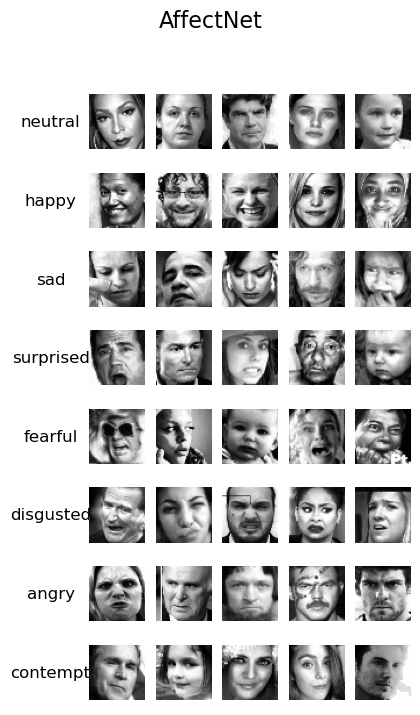

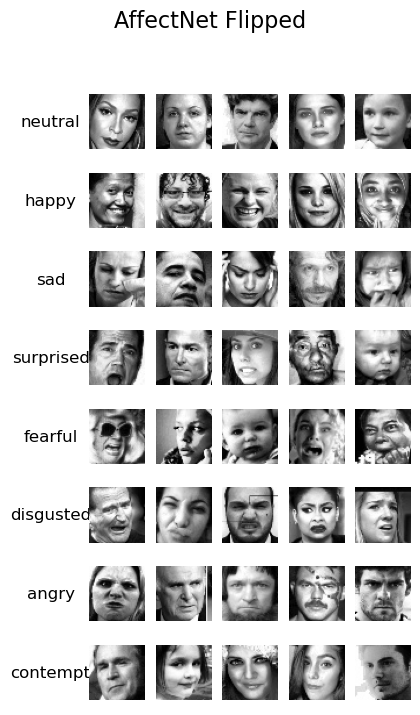

In [3]:
from load_datasets import display_dataframe
    
display_dataframe(df_affectnet, 'AffectNet')
display_dataframe(df_affectnet_flipped, 'AffectNet Flipped')

In [3]:
display(df_affectnet['class'].value_counts().sort_index())
display(df_affectnet.shape)

display(df_affectnet_flipped['class'].value_counts().sort_index())
display(df_affectnet_flipped.shape)

0     75374
1    134915
2     25959
3     14590
4      6878
5      4303
6     25382
7      4249
Name: class, dtype: int64

(291650, 2)

0     75374
1    134915
2     25959
3     14590
4      6878
5      4303
6     25382
7      4249
Name: class, dtype: int64

(291650, 2)

## Divisão treino e teste

In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd

x_train, x_test, y_train, y_test = train_test_split(df_affectnet['path_img'], df_affectnet['class'], test_size=0.1, stratify=df_affectnet['class'])

x_train = pd.concat([x_train, df_affectnet_flipped['path_img']], ignore_index=True)
y_train = pd.concat([y_train, df_affectnet_flipped['class']], ignore_index=True)

print("Número de amostras do treinamento:", len(x_train))
print("Número de amostras do teste:", len(x_test))

Número de amostras do treinamento: 554135
Número de amostras do teste: 29165


In [4]:
import numpy as np
import cv2
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(rescale=1./255)

def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (48, 48))
    img = np.expand_dims(img, axis=2)
    return img

def load_images(paths):
    imgs = []
    for path in paths:
        imgs.append(load_image(path))
    return np.array(imgs)

def load_dataset(paths, labels):
    imgs = load_images(paths)
    return imgs, labels

def load_generator(paths, labels, batch_size):
    return data_generator.flow(load_images(paths), labels, batch_size=batch_size)

train_generator = load_generator(x_train, y_train, 64)
test_generator = load_generator(x_test, y_test, 64)

2023-03-15 20:28:15.342138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 20:28:15.668349: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-15 20:28:15.726105: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/guilherme/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-03-15 2

## Instanciando modelos

In [5]:
from tensorflow import keras

cnn = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(8, activation='softmax')
])

cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

2023-03-15 20:30:05.082896: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/guilherme/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-03-15 20:30:05.083426: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-15 20:30:05.084479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gfumagali): /proc/driver/nvidia/version does not exist
2023-03-15 20:30:05.100278: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow wi

In [6]:
from tensorflow.keras.applications.resnet50 import ResNet50

resnet = keras.models.Sequential([
    ResNet50(include_top=False, weights=None, input_shape=(48, 48, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(8, activation='softmax')
])

resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg = keras.models.Sequential([
    VGG16(include_top=False, weights=None, input_shape=(48, 48, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(8, activation='softmax')
])

vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Experimentos

In [6]:
cnn.fit(train_generator, epochs=5, validation_data=test_generator, use_multiprocessing=True)
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(cnn.history)

#export weights
cnn.save_weights('cnn.h5')

Epoch 1/5
8659/8659 [==============================] - ETA: 0s - loss: 0.9570 - accuracy: 0.6698

In [ ]:
resnet.fit(train_generator, epochs=5, validation_data=test_generator, use_multiprocessing=True)

In [ ]:
vgg.fit(train_generator, epochs=5, validation_data=test_generator, use_multiprocessing=True)